<a href="https://colab.research.google.com/github/CarlTeapot/Facial-Expression-Recognition/blob/main/ModelExperiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install opendatasets

In [2]:
import opendatasets as od
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [3]:
od.download("https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: matearevadze
Your Kaggle Key: ··········


100%|██████████| 285M/285M [00:00<00:00, 849MB/s]



Extracting archive ./challenges-in-representation-learning-facial-expression-recognition-challenge/challenges-in-representation-learning-facial-expression-recognition-challenge.zip to ./challenges-in-representation-learning-facial-expression-recognition-challenge


In [4]:
train_data = pd.read_csv("/content/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv")

In [5]:
def convertToTensors(df):
    image_matrix = np.vstack(df['pixels'].str.split().apply(lambda x: np.array(x, dtype='float32')))
    image_tensor = image_matrix.reshape(-1, 1, 48, 48)
    label_tensor = df['emotion'].values.astype('int64')
    return torch.tensor(image_tensor), torch.tensor(label_tensor)

In [7]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [95]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


x,y = convertToTensors(train_data)


x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [96]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [97]:
class FERDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if isinstance(img, torch.Tensor):
            img = img.squeeze().numpy()
        img = Image.fromarray((img * 255).astype(np.uint8), mode='L')

        if self.transform:
            img = self.transform(img)

        return img, label

In [98]:

# train_dataset = FERDataset(x_train, y_train, transform=train_transform)
# val_dataset = FERDataset(x_val, y_val, transform=basic_transform)
# test_dataset = FERDataset(x_test, y_test, transform=basic_transform)

train_dataset = FERDataset(x_train, y_train, transform=train_transform)
val_dataset = FERDataset(x_val, y_val, transform=transforms.ToTensor())
test_dataset = FERDataset(x_test, y_test, transform=transforms.ToTensor())

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=BATCH_SIZE)

In [81]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(48 * 48, 128)
        self.relu = nn.ReLU()
        self.output = nn.Linear(128, 7)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.output(x)
        return x

In [82]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.output = nn.Linear(32 * 24 * 24, 7)

    def forward(self, x):
        x = self.pooling(self.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


In [83]:

class CNNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.linear = nn.Linear(128 * 6 * 6, 128)
        self.output = nn.Linear(128, 7)

    def forward(self, x):
        x = self.pooling(self.relu(self.conv1(x)))
        x = self.pooling(self.relu(self.conv2(x)))
        x = self.pooling(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.linear(x))
        x = self.output(x)
        return x


In [92]:
import torch.nn as nn

class CNNet3(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


In [93]:

def train_with_wandb(model, train_loader, val_loader, optimizer,
                     epochs, architecture, criterion, learning_rate, run_name="run"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    wandb.init(project="fer2013", name=run_name, config={
        "epochs": epochs,
        "architecture": architecture,
        "optimizer": optimizer.__class__.__name__,
        "loss_function": criterion.__class__.__name__,
        "learning_rate": learning_rate,
        "batch_size": train_loader.batch_size
    })

    total_loss_train_plot = []
    total_loss_validation_plot = []
    total_acc_train_plot = []
    total_acc_validation_plot = []

    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        total_loss_val = 0
        total_acc_val = 0

        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            total_loss_train += train_loss.item()
            train_loss.backward()
            optimizer.step()

            train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_train += train_acc

        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_loss_val += val_loss.item()
                val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
                total_acc_val += val_acc

        num_train = len(train_loader.dataset)
        num_val = len(val_loader.dataset)

        avg_loss_train = total_loss_train / len(train_loader)
        avg_loss_val = total_loss_val / len(val_loader)
        acc_train = 100 * total_acc_train / num_train
        acc_val = 100 * total_acc_val / num_val

        total_loss_train_plot.append(round(avg_loss_train, 4))
        total_loss_validation_plot.append(round(avg_loss_val, 4))
        total_acc_train_plot.append(round(acc_train, 4))
        total_acc_validation_plot.append(round(acc_val, 4))

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_loss_train,
            "val_loss": avg_loss_val,
            "train_accuracy": acc_train,
            "val_accuracy": acc_val
        })

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_loss_train:.4f} | Train Acc: {acc_train:.2f}%")
        print(f"  Val   Loss: {avg_loss_val:.4f} | Val   Acc: {acc_val:.2f}%")
        print("=" * 30)

    wandb.finish()

    return {
        "train_loss": total_loss_train_plot,
        "val_loss": total_loss_validation_plot,
        "train_accuracy": total_acc_train_plot,
        "val_accuracy": total_acc_validation_plot
    }


In [ ]:
model = CNNet3().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)
train_with_wandb(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    epochs=30,
    architecture="CNN_model_v4",
    criterion=criterion,
    learning_rate=0.005,
    run_name="CNN_model_v6_data_standardization_and_regularization"
)

Epoch 1/30
  Train Loss: 1.6860 | Train Acc: 32.52%
  Val   Loss: 1.7138 | Val   Acc: 35.81%
Epoch 2/30
  Train Loss: 1.5096 | Train Acc: 41.65%
  Val   Loss: 1.5885 | Val   Acc: 39.39%
Epoch 3/30
  Train Loss: 1.4329 | Train Acc: 44.86%
  Val   Loss: 1.5309 | Val   Acc: 41.48%
Epoch 4/30
  Train Loss: 1.3905 | Train Acc: 46.93%
  Val   Loss: 1.5380 | Val   Acc: 40.82%
Epoch 5/30
  Train Loss: 1.3518 | Train Acc: 48.33%
  Val   Loss: 1.4231 | Val   Acc: 46.29%
Epoch 6/30
  Train Loss: 1.3286 | Train Acc: 49.50%
  Val   Loss: 1.4032 | Val   Acc: 45.63%
Epoch 7/30
  Train Loss: 1.3055 | Train Acc: 49.93%
  Val   Loss: 1.3689 | Val   Acc: 47.37%
Epoch 8/30
  Train Loss: 1.2811 | Train Acc: 51.07%
  Val   Loss: 1.3716 | Val   Acc: 46.60%
Epoch 9/30
  Train Loss: 1.2694 | Train Acc: 51.57%
  Val   Loss: 1.3365 | Val   Acc: 49.81%
Epoch 10/30
  Train Loss: 1.2535 | Train Acc: 52.00%
  Val   Loss: 1.4711 | Val   Acc: 42.63%
Epoch 11/30
  Train Loss: 1.2411 | Train Acc: 52.94%
  Val   Loss: 1.

In [90]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [91]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 54.75%


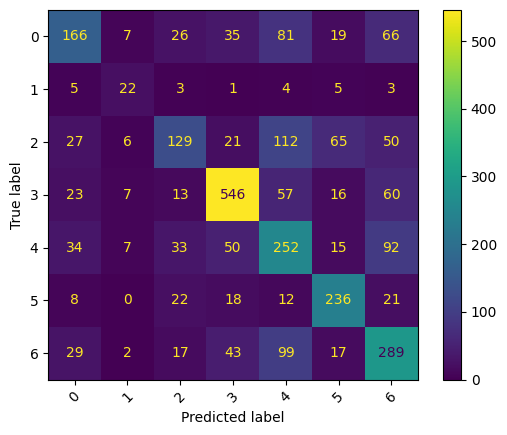

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)

In [44]:

with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        predictions = model(inputs)

        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_test += acc

        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test / len(test_loader)) * 100, 4)} and Loss is {round(total_loss_test / len(test_loader), 4)}")


Accuracy Score is: 846.1111 and Loss is 1.7393


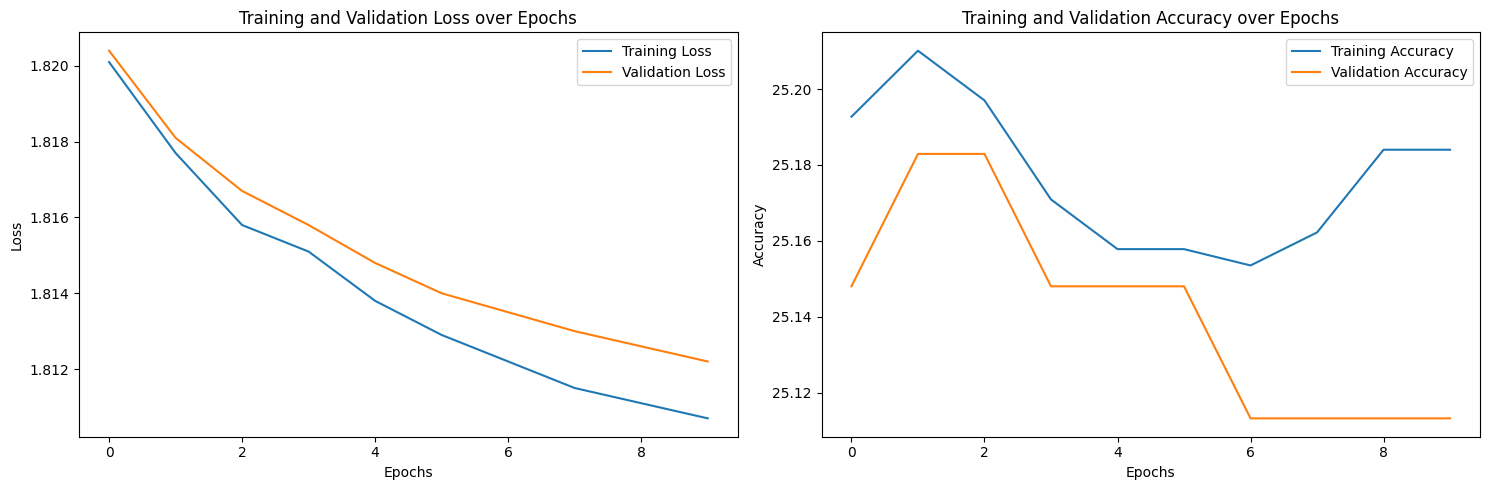

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()